# Caracterização de eletrofáceis por meio de inteligência artificial com abordagem supervisionada
## Treinamento teste e análise do modelo

- **Nome do Arquivo**: treinamento_modelo.ipynb
- **Autor**: Rafael Takeguma Goto
- **Versão**: 1.0
- **Data de Criação**: 24/06/2024
- **Data de Modificação**: 26/07/2024

### Descrição: 
Este notebook contém a etapa do trabalho referente à realização do treinamento, teste e análise do algoritmo de identificação de eletrofáceis a partir dos dados rotulados.

### Leitura do conjunto de dados
O conjunto de dados é constituído por um arquivo csv, que é resultado da concatenação dos arquivos csv gerados a partir da fusão da extração dos arquivos dlis com os arquivos agp de cada poço, seguida da aplicação dos seguintes processamentos:
- filtros de constantes 
- filtros de nulos
- filtros de perfis (DCAL e DRHO)
- reclassificação da litologia metamórfica

In [1]:
import pandas as pd

path_pocos_pre_transicao = 'Dados-filtrados-concatenados\pocos_pre_transicao_v2.csv'

dados_concatenados_leitura = pd.read_csv(path_pocos_pre_transicao)

dados_concatenados = pd.DataFrame(dados_concatenados_leitura)

In [2]:
# renomeia abreviaturas das unidades formação
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'COTING', 'UnidadeF'] = 'COT'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'SERRAR', 'UnidadeF'] = 'SER'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'BATING', 'UnidadeF'] = 'BAT'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'ARACAR', 'UnidadeF'] = 'ARA'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'PENEDO', 'UnidadeF'] = 'PDO'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'RIACHU', 'UnidadeF'] = 'RIA'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'BANANE', 'UnidadeF'] = 'BAN'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'MURIBE', 'UnidadeF'] = 'MUR'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'EMBASA', 'UnidadeF'] = 'EMB'
dados_concatenados.loc[dados_concatenados['UnidadeF'] == 'BARRRS', 'UnidadeF'] = 'BAR'

# renomeia abreviaturas das unidades membro
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'SAPUCA', 'UnidadeM'] = 'SAP'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'SERRAR', 'UnidadeM'] = 'SER'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'ARACAR', 'UnidadeM'] = 'ARA'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'BATING', 'UnidadeM'] = 'BAT'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'PENEDO', 'UnidadeM'] = 'PDO'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'BANANE', 'UnidadeM'] = 'BAN'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'EMBASA', 'UnidadeM'] = 'EMB'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'TAQUAR', 'UnidadeM'] = 'TQR'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'MARUIM', 'UnidadeM'] = 'MAR'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'ANGICO', 'UnidadeM'] = 'ANG'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'OITEIR', 'UnidadeM'] = 'OIT'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'IBURA', 'UnidadeM'] = 'IBU'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'CARMOP', 'UnidadeM'] = 'CPS'
dados_concatenados.loc[dados_concatenados['UnidadeM'] == 'BARRRS', 'UnidadeM'] = 'BAR'

In [5]:
# Criando uma coluna para unidade em nível de membro
dados_concatenados['Unidade_nivel_membro'] = dados_concatenados['UnidadeF'] + '_' + dados_concatenados['UnidadeM']

In [6]:
dados_concatenados['Unidade_nivel_membro'].unique()

array(['RIA_ANG', 'MUR_OIT', 'MUR_IBU', 'MUR_CPS', 'EMB_EMB', 'RIA_MAR',
       'RIA_TQR', 'BAN_BAN', 'PDO_PDO', 'BAR_BAR', 'SER_SER', 'ARA_ARA',
       'BAT_BAT', 'COT_SAP'], dtype=object)

### Aplica One Hot Encoding
Transforma os valores das unidades geológicas, contidos na coluna Unidade_nivel_membro para colunas binárias.

In [7]:
# Aplicando One-Hot Encoding
dados_concatenados = pd.get_dummies(dados_concatenados, columns=['Unidade_nivel_membro'])

In [10]:
# Função para contar todas as combinações existentes na hierarquia de formação e membro
def count_all_combinations(df, formacao, membro):
    combinations = df.groupby([formacao, membro]).size()
    combinations_dict = {f"{a}_{b}": count for (a, b), count in combinations.items()}
    return combinations_dict

count_all_combinations(dados_concatenados, 'UnidadeF', 'UnidadeM')

{'ARA_ARA': 378,
 'BAN_BAN': 2207,
 'BAR_BAR': 2,
 'BAT_BAT': 1417,
 'COT_SAP': 45,
 'EMB_EMB': 1747,
 'MUR_CPS': 5289,
 'MUR_IBU': 4554,
 'MUR_OIT': 3466,
 'PDO_PDO': 1358,
 'RIA_ANG': 5986,
 'RIA_MAR': 3432,
 'RIA_TQR': 6972,
 'SER_SER': 447}

In [11]:
dados_concatenados.columns

Index(['Unnamed: 0', 'Poço', 'Profundidade', 'UnidadeF', 'UnidadeM',
       'UnidadeC', 'TopoUnidade', 'BaseUnidade', 'Topo', 'Base', 'Litologia',
       'Cor', 'Tonalidade', 'Granulometria', 'Arredondamento', 'BS', 'CAL',
       'DCAL', 'GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'interpolada',
       'PE.1', 'Unidade_nivel_membro_ARA_ARA', 'Unidade_nivel_membro_BAN_BAN',
       'Unidade_nivel_membro_BAR_BAR', 'Unidade_nivel_membro_BAT_BAT',
       'Unidade_nivel_membro_COT_SAP', 'Unidade_nivel_membro_EMB_EMB',
       'Unidade_nivel_membro_MUR_CPS', 'Unidade_nivel_membro_MUR_IBU',
       'Unidade_nivel_membro_MUR_OIT', 'Unidade_nivel_membro_PDO_PDO',
       'Unidade_nivel_membro_RIA_ANG', 'Unidade_nivel_membro_RIA_MAR',
       'Unidade_nivel_membro_RIA_TQR', 'Unidade_nivel_membro_SER_SER'],
      dtype='object')

### Verifica quantidade total de amostras por litologia

In [4]:
"""
# armazena as diferentes litologias existentes na variável 'litologias'
litologias = dados_concatenados['Litologia'].unique()

for litologia in litologias:
    qtde_litologia = len(dados_concatenados[dados_concatenados['Litologia'] == litologia])
    print(f'{litologia}: {qtde_litologia} registros')
"""

"\n# armazena as diferentes litologias existentes na variável 'litologias'\nlitologias = dados_concatenados['Litologia'].unique()\n\nfor litologia in litologias:\n    qtde_litologia = len(dados_concatenados[dados_concatenados['Litologia'] == litologia])\n    print(f'{litologia}: {qtde_litologia} registros')\n"

### Verifica quantidade de amostras para treinamento por litologia

In [5]:
"""
litologia_train_set = pd.DataFrame(y_train)

for litologia in litologias:
    qtde_litologia = len(litologia_train_set[litologia_train_set['Litologia'] == litologia])
    print(f'{litologia}: {qtde_litologia} registros')
"""


"\nlitologia_train_set = pd.DataFrame(y_train)\n\nfor litologia in litologias:\n    qtde_litologia = len(litologia_train_set[litologia_train_set['Litologia'] == litologia])\n    print(f'{litologia}: {qtde_litologia} registros')\n"

### Função para criar, treinar e testar o modelo
Cria função cria_modelo(dados, unidades), que toma como parâmetros os dados das litologias, perfis e unidades (se unidades for True) e retorna o modelo treinado.

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def cria_modelo(dados, unidades=bool):
    """
    Função que treina, testa e retorna o modelo.
    Divide os dados armazenados em dados em 2/3 para treinamento do modelo, 
    e 1/3 para teste do modelo.
    Utiliza os dados de treinamento armazenados em X_train e y_train 
    para treinar o modelo de classificação. 
    De forma semelhante, utiliza os dados de teste armazenados em X_test e y_test 
    para testar a acurácia do modelo.
    Por fim, retorna o modelo e a acurácia média e o desvio padrão da acurácia.
    

    Args:
        dados(DataFrame): DataFrame pandas que contém os dados das curvas, litologias e unidades
        unidades(bool): Verdadeiro ou Falso. Unidades serão variáveis preditivas ou não.

    Returns:
        modelo(sklearn.ensemble._forest.RandomForestClassifier): Modelo treinado
        y_pred(numpy.ndarray): Dados preditos para serem usados na matriz de confusão
        y_test(pandas.core.series.Series): Dados de teste para serem usados na matriz de confusão
        acuracia_media(float): Acurácia média do modelo
        desvio_padrao_acuracia(float): Desvio padrão da acurácia do modelo
    """
    # Define se as unidades geológicas serão incluídas ou não
    if unidades == False:
        # Define as variáveis preditivas que serão utilizadas (apenas propriedades de perfis, sem unidades geológicas) 
        variaveis_preditivas = ['GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']
    else:
        # Define as variáveis preditivas que serão utilizadas (propriedades de perfis e unidades geológicas)
        variaveis_preditivas = ['GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE', 'Unidade_nivel_membro_BAN_BAN',
       'Unidade_nivel_membro_BAR_BAR', 'Unidade_nivel_membro_BAT_BAT',
       'Unidade_nivel_membro_COT_SAP', 'Unidade_nivel_membro_EMB_EMB',
       'Unidade_nivel_membro_MUR_CPS', 'Unidade_nivel_membro_MUR_IBU',
       'Unidade_nivel_membro_MUR_OIT', 'Unidade_nivel_membro_PDO_PDO',
       'Unidade_nivel_membro_RIA_ANG', 'Unidade_nivel_membro_RIA_MAR',
       'Unidade_nivel_membro_RIA_TQR', 'Unidade_nivel_membro_SER_SER']

    # Separa as variáveis preditivas e armazena em X
    X = dados[variaveis_preditivas] 

    # Separa a variável alvo (litologia) e armazena em y
    y = dados['Litologia']   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

    # Treina o modelo
    modelo = RandomForestClassifier()
    modelo.fit(X_train, y_train)

    # Faz previsões com o modelo
    y_pred = modelo.predict(X_test)

    # Calcula a acuracia
    acuracia = accuracy_score(y_test, y_pred)
    print(f"Acurácia do modelo: {acuracia:2f}")

    """
    # Validação cruzada para calcular a acurácia média e o desvio padrão da acurácia
    scores = cross_val_score(modelo, X, y, cv=5)
    acuracia_media = np.mean(scores)
    desvio_padrao_acuracia = np.std(scores)
    print(f"Acurácia média: {acuracia_media:.2f}")
    print(f"Desvio padrão da acurácia: {desvio_padrao_acuracia:.2f}")
    """

    return modelo, y_pred, y_test#, acuracia_media, desvio_padrao_acuracia

In [7]:
modelo_01, dados_preditos, dados_verdadeiros = cria_modelo(dados_concatenados, False)

Acurácia do modelo: 0.821296


In [8]:
type(modelo_01)

sklearn.ensemble._forest.RandomForestClassifier

### Matriz de Confusão

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Função para criar a matriz de confusão
def cria_matriz_confusao(matriz_confusao, modelo):
    """
    Cria (plota) matriz de confusão

    Args:
        matriz_confusao (numpy.ndarray): matriz de confusão criada a partir de confusion_matrix().
        modelo (sklearn.ensemble._forest.RandomForestClassifier): modelo RandomForestClassifier()
    """

    # Normaliza a matriz de confusão por linha
    matriz_confusao_normalizada = matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis]
    
    # Rótulos das litologias
    categorias = modelo.classes_

    # Cria strings com os valores absolutos e porcentagem de cada célula da matriz
    num_absoluto_porcentagem = np.empty_like(matriz_confusao, dtype=object)
    for i in range(matriz_confusao.shape[0]):
        for j in range(matriz_confusao.shape[1]):
            num_absoluto_porcentagem[i, j] = f'{matriz_confusao[i, j]}\n{matriz_confusao_normalizada[i, j]:.1%}'
    
    # Tamanho da figura
    plt.figure(figsize=(12,8))
    
    # Objeto dos eixos
    ax = plt.gca()
    
    # Remove traços dos eixos
    ax.tick_params(axis='x', which='both', bottom=False, top=False)  
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    # Cria o heatmap
    heatmap = sns.heatmap(matriz_confusao_normalizada, 
                annot=num_absoluto_porcentagem, 
                fmt='',
                cmap='BuGn', 
                xticklabels=categorias, 
                yticklabels=categorias,
                cbar_kws={'label': 'Proporção da Litologia'},
                annot_kws={"size": 12},
                linewidths=0.7,
                linecolor='gray')
    
    # Modifica a barra de cores para mostrar de 0% a 100%
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    # Rótulos dos eixos
    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    
    plt.show()

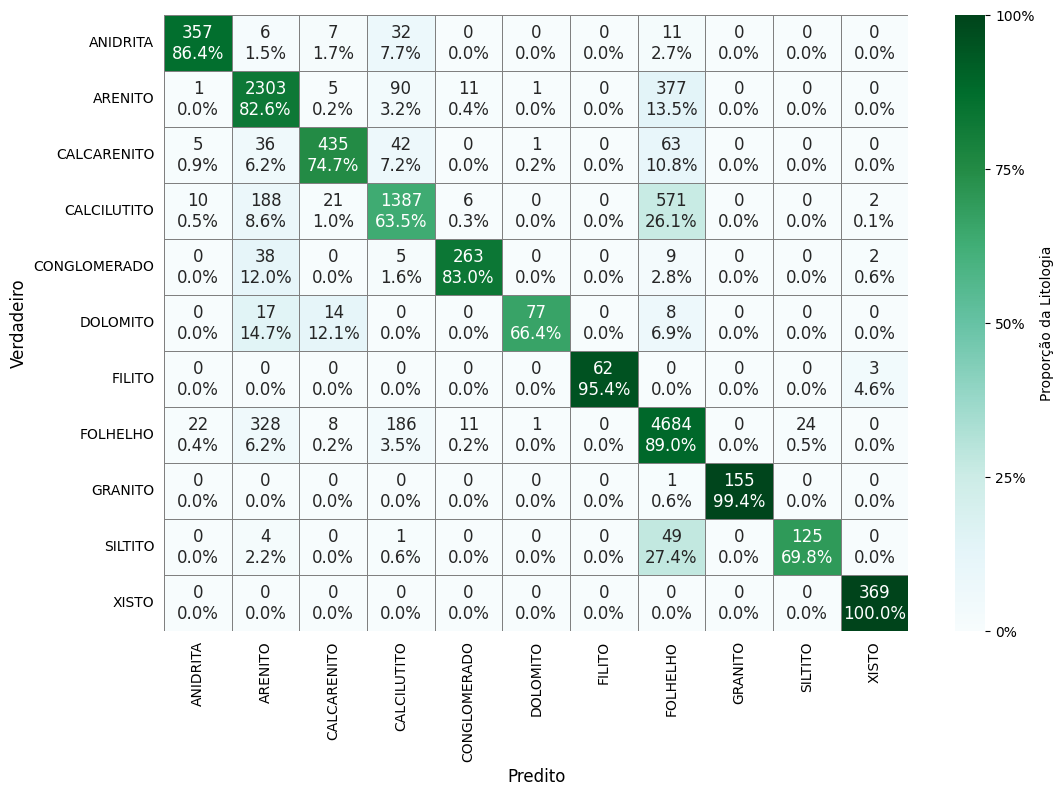

In [9]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_01 = confusion_matrix(dados_verdadeiros, dados_preditos)

cria_matriz_confusao(matriz_confusao_01, modelo_01)

## Dados sem balanceamento e com unidades geológicas

In [13]:
modelo_02, dadaos_preditos_02, dados_verdadeiros_02 = cria_modelo(dados_concatenados, True)

Acurácia do modelo: 0.852582


### Matriz de Confusão

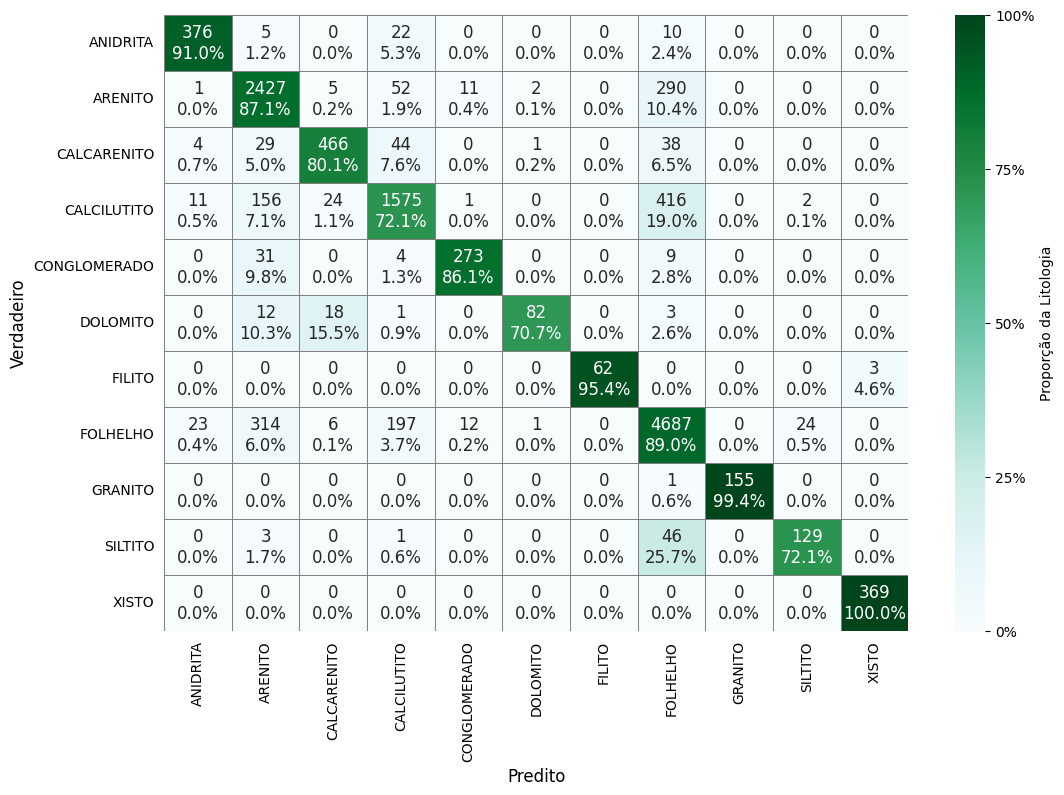

In [16]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_02 = confusion_matrix(dados_verdadeiros_02, dadaos_preditos_02)

cria_matriz_confusao(matriz_confusao_02, modelo_02)

## Dados com balanceamento (undersampling por unidades) e com unidades geológicas 
### Realiza undersampling do FOLHELHO por unidades geológicas

In [17]:
from pre_processamento import *

# Cria a nova coluna combinando os valores de UnidadeF e UnidadeM
dados_concatenados['Unidade_comb'] = dados_concatenados['UnidadeF'] + '_' + dados_concatenados['UnidadeM']

In [21]:
dados_folhelho = conta_registros_litologia_unidade(dados_concatenados, 'FOLHELHO')
dados_folhelho

{'ARA_ARA': 185,
 'BAN_BAN': 2152,
 'BAR_BAR': 2,
 'BAT_BAT': 702,
 'COT_SAP': 3,
 'MUR_CPS': 1904,
 'MUR_IBU': 1898,
 'MUR_OIT': 1720,
 'PDO_PDO': 225,
 'RIA_ANG': 2330,
 'RIA_MAR': 756,
 'RIA_TQR': 3923,
 'SER_SER': 59}

In [18]:
import math

def realiza_undersampling(dados, litologias, proporcao):
    dados_balanceados = dados.copy()

    for litologia in litologias:
    
        dados_litologia = conta_registros_litologia_unidade(dados_balanceados, litologia)

        for unidade, registros in dados_litologia.items():
            qtde_remocao = math.floor(registros * proporcao)
            
            linhas_unidade = dados_balanceados[(
                (dados_balanceados['Unidade_comb'] == unidade) & 
                (dados_balanceados['Litologia'] == litologia))]

            linhas_aleatorias = linhas_unidade.sample(n=qtde_remocao, random_state=42)
                
            dados_balanceados = dados_balanceados.drop(linhas_aleatorias.index)

    return dados_balanceados

In [27]:
dados_balanceados_folhelho = realiza_undersampling(dados_concatenados, ['FOLHELHO'], 3/4)

In [28]:
dados_folhelho_2 = conta_registros_litologia_unidade(dados_balanceados_folhelho, 'FOLHELHO')
dados_folhelho_2

{'ARA_ARA': 47,
 'BAN_BAN': 538,
 'BAR_BAR': 1,
 'BAT_BAT': 176,
 'COT_SAP': 1,
 'MUR_CPS': 476,
 'MUR_IBU': 475,
 'MUR_OIT': 430,
 'PDO_PDO': 57,
 'RIA_ANG': 583,
 'RIA_MAR': 189,
 'RIA_TQR': 981,
 'SER_SER': 15}

In [29]:
def visualiza_undersampling(dict1, dict2):
    # Obter todas as chaves de ambos os dicionários
    todas_chaves = set(dict1.keys()).union(set(dict2.keys()))
    
    # Ordenar as chaves para uma exibição consistente
    todas_chaves = sorted(todas_chaves)
    
    # Obter os valores correspondentes a cada chave em ambos os dicionários
    valores1 = [dict1.get(chave, 0) for chave in todas_chaves]
    valores2 = [dict2.get(chave, 0) for chave in todas_chaves]
    
    # Configurar a largura das barras e as posições das chaves no eixo x
    largura = 0.35
    x = np.arange(len(todas_chaves))
    
    # Criar a figura e os eixos
    fig, ax = plt.subplots()
    
    # Plotar os dados de ambos os dicionários
    barras1 = ax.bar(x - largura/2, valores1, largura, label='Antes')
    barras2 = ax.bar(x + largura/2, valores2, largura, label='Depois')
    
    # Adicionar rótulos e título
    ax.set_xlabel('Unidades')
    ax.set_ylabel('Número de amostras')
    # ax.set_title('Comparação do número de amostras por Unidade Geológica')
    ax.set_xticks(x)
    ax.set_xticklabels(todas_chaves, rotation=45, ha='right')
    ax.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

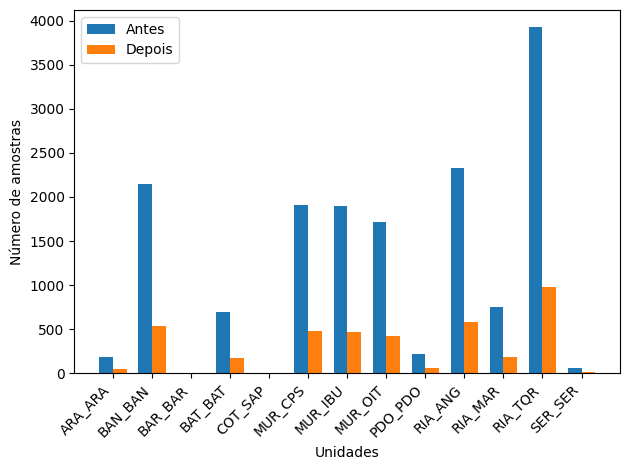

In [32]:
visualiza_undersampling(dados_folhelho, dados_folhelho_2)

In [31]:
modelo_04, dados_preditos_04, dados_verdadeiros_04 = cria_modelo(dados_balanceados_folhelho, True)

Acurácia do modelo: 0.855608


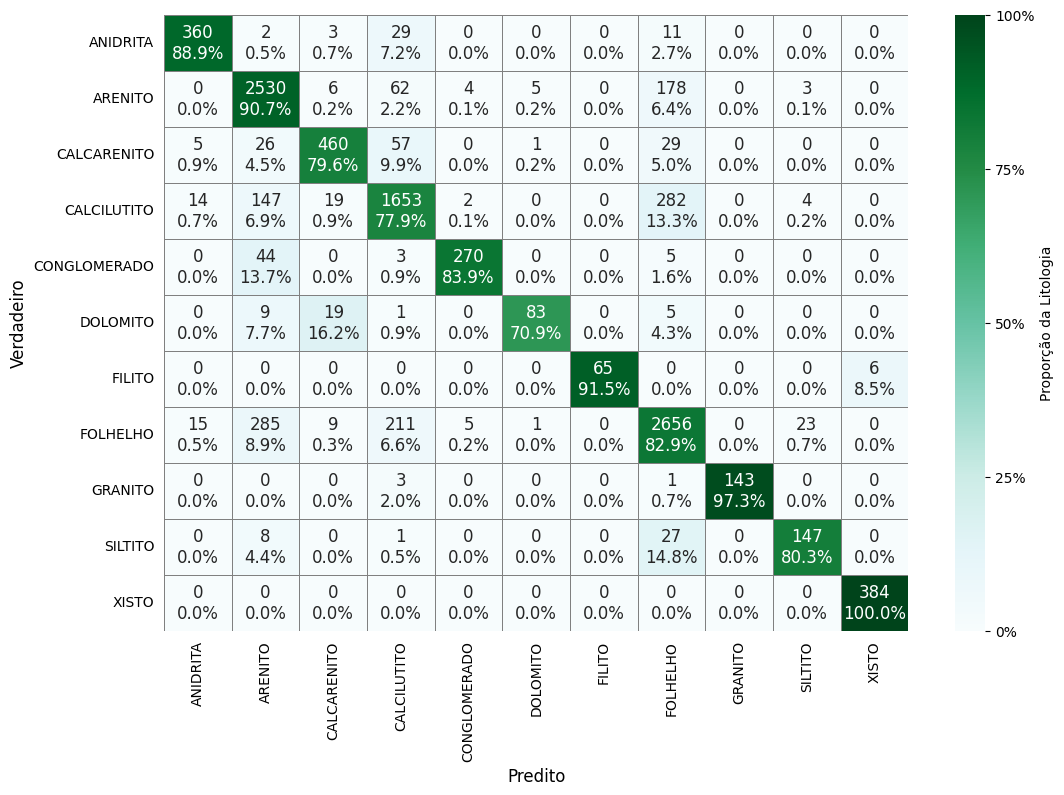

In [26]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_04 = confusion_matrix(dados_verdadeiros_04, dados_preditos_04)

cria_matriz_confusao(matriz_confusao_04, modelo_04)

## Dados com balanceamento (undersampling por unidades) e sem unidades geológicas 
### Realiza undersampling do FOLHELHO por unidades geológicas

In [32]:
modelo_21, dados_preditos_21, dados_verdadeiros_21 = cria_modelo(dados_balanceados_folhelho, False)

Acurácia do modelo: 0.819237


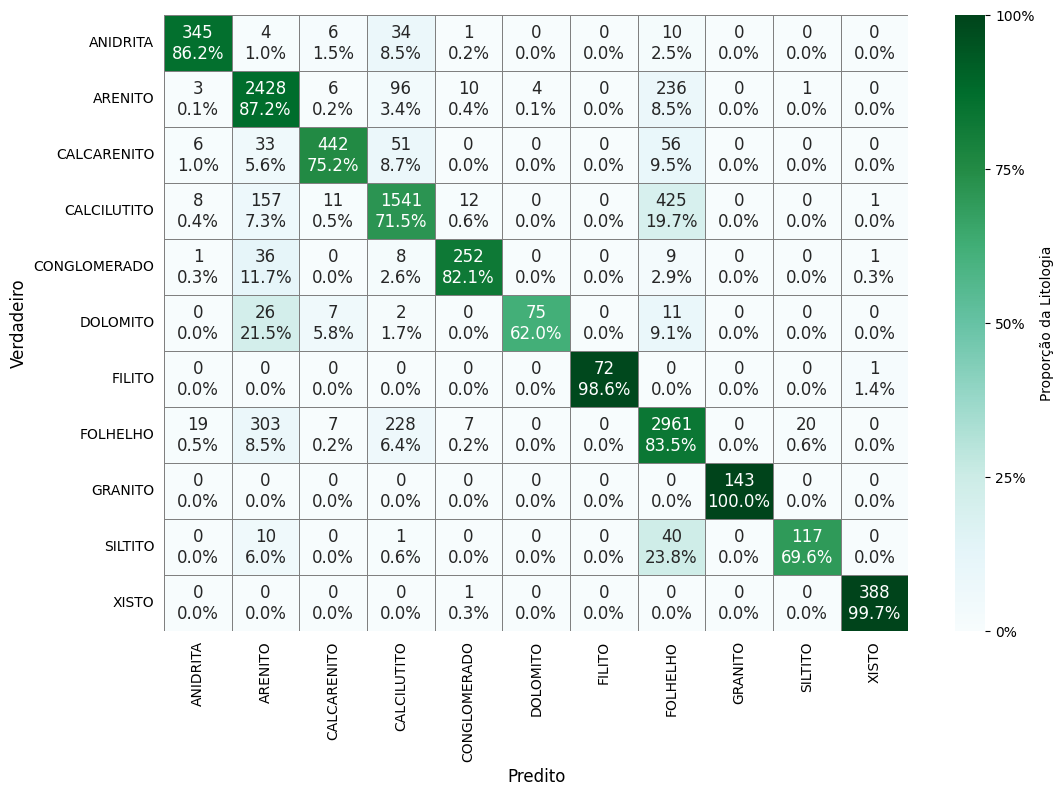

In [23]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_21 = confusion_matrix(dados_verdadeiros_21, dados_preditos_21)

cria_matriz_confusao(matriz_confusao_21, modelo_21)

## Dados com balanceamento (undersampling por unidades) e com unidades geológicas 
### Realiza undersampling do FOLHELHO e do ARENITO por unidades geológicas

In [ ]:
dados_arenito = conta_registros_litologia_unidade(dados_balanceados_folhelho, 'ARENITO')
dados_arenito

{'BAN_BAN': 20,
 'BAT_BAT': 233,
 'MUR_CPS': 2009,
 'MUR_IBU': 418,
 'MUR_OIT': 692,
 'PDO_PDO': 1097,
 'RIA_ANG': 2855,
 'RIA_MAR': 295,
 'RIA_TQR': 501,
 'SER_SER': 388}

In [20]:
dados_balanceados_arenito = realiza_undersampling(dados_balanceados_folhelho, ['ARENITO'], 1/5)

In [ ]:
dados_arenito_02 = conta_registros_litologia_unidade(dados_balanceados_arenito, 'ARENITO')
dados_arenito_02

{'BAN_BAN': 16,
 'BAT_BAT': 187,
 'MUR_CPS': 1608,
 'MUR_IBU': 335,
 'MUR_OIT': 554,
 'PDO_PDO': 878,
 'RIA_ANG': 2284,
 'RIA_MAR': 236,
 'RIA_TQR': 401,
 'SER_SER': 311}

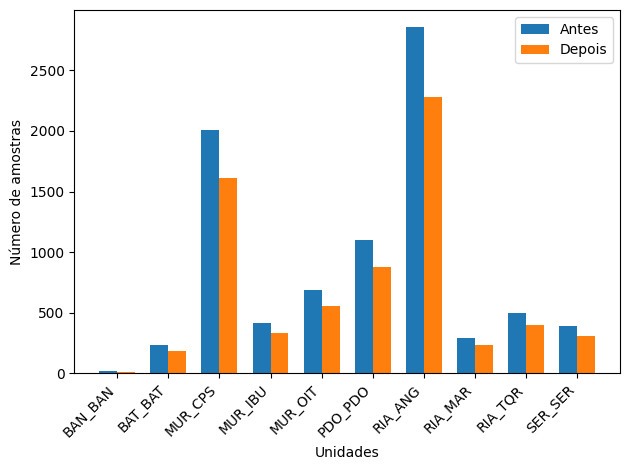

In [ ]:
visualiza_undersampling(dados_arenito, dados_arenito_02)

In [21]:
modelo_05, dados_preditos_05, dados_verdadeiros_05 = cria_modelo(dados_balanceados_arenito, True)

Acurácia do modelo: 0.863758
Acurácia média: 0.49
Desvio padrão da acurácia: 0.08


ValueError: too many values to unpack (expected 3)

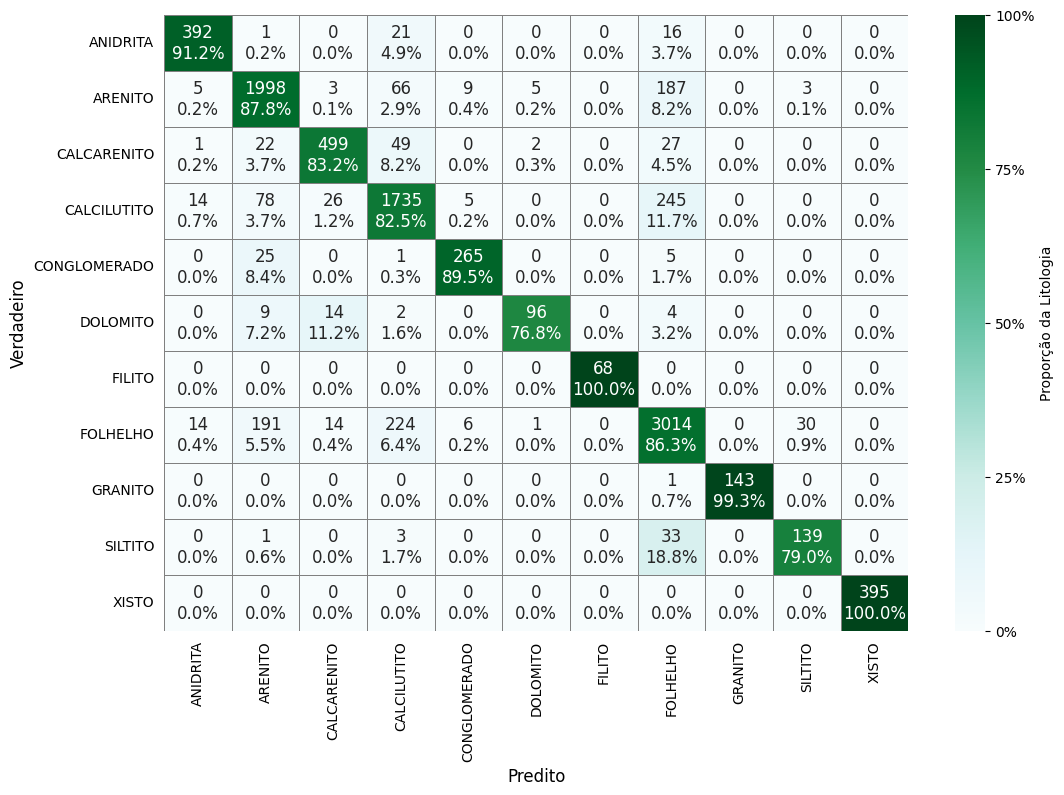

In [ ]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_05 = confusion_matrix(dados_verdadeiros_05, dados_preditos_05)

cria_matriz_confusao(matriz_confusao_05, modelo_05)

===========

In [22]:
dados_balanceados_calcilutito = realiza_undersampling(dados_balanceados_arenito, ['CALCILUTITO', 'CALCARENITO', 'ANIDRITA'], 1/6)

In [23]:
modelo_06, dados_preditos_06, dados_verdadeiros_06, acuracia_06, dp_06 = cria_modelo(dados_balanceados_calcilutito, True)

Acurácia do modelo: 0.868377
Acurácia média: 0.49
Desvio padrão da acurácia: 0.09


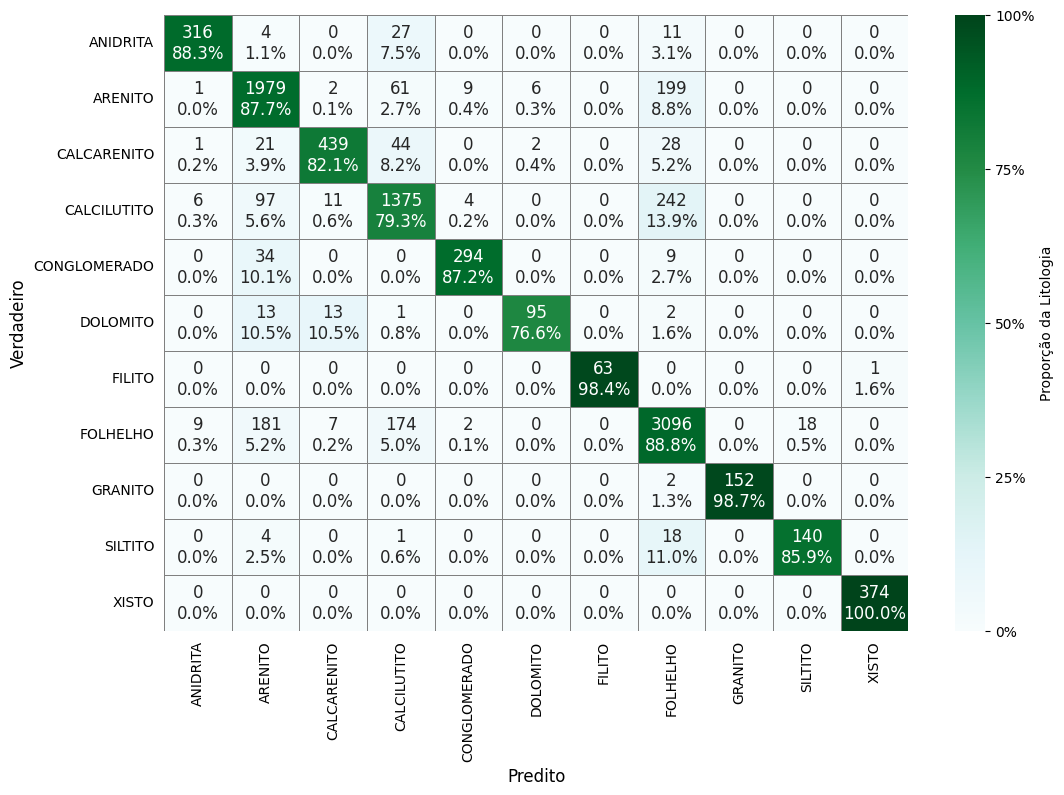

In [ ]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_06 = confusion_matrix(dados_verdadeiros_06, dados_preditos_06)

cria_matriz_confusao(matriz_confusao_06, modelo_06)

## Dados com balanceamento (undersampling) e com unidades geológicas 
### Realiza undersampling da classe majoritária

In [ ]:
# Separar as instâncias de 'FOLHELHO'
folhelho_df = dados_concatenados[dados_concatenados['Litologia'] == 'FOLHELHO']

# Realizar uma amostragem aleatória de 6300 instâncias de 'FOLHELHO'
folhelho_sampled = folhelho_df.sample(n=2000, random_state=42)

In [ ]:
# Combinar as instâncias amostradas com as outras categorias
demais_litologias_df = dados_concatenados[dados_concatenados['Litologia'] != 'FOLHELHO']

In [ ]:
dados_concatenados_folhelho_under = pd.concat([folhelho_sampled, demais_litologias_df])

In [ ]:
# Separar as instâncias de 'FOLHELHO'
arenito_df = dados_concatenados_folhelho_under[dados_concatenados_folhelho_under['Litologia'] == 'ARENITO']

# Realizar uma amostragem aleatória de 6300 instâncias de 'FOLHELHO'
arenito_sampled = arenito_df.sample(n=2000, random_state=42)

# Combinar as instâncias amostradas com as outras categorias
demais_litologias_df_02 = dados_concatenados_folhelho_under[dados_concatenados_folhelho_under['Litologia'] != 'ARENITO']

dados_concatenados_arenito_under = pd.concat([arenito_sampled, demais_litologias_df_02])

In [ ]:
# Separar as instâncias de 'FOLHELHO'
calcilutito_df = dados_concatenados_arenito_under[dados_concatenados_arenito_under['Litologia'] == 'CALCILUTITO']

# Realizar uma amostragem aleatória de 6300 instâncias de 'FOLHELHO'
calcilutito_sampled = calcilutito_df.sample(n=2000, random_state=42)

# Combinar as instâncias amostradas com as outras categorias
demais_litologias_df_03 = dados_concatenados_arenito_under[dados_concatenados_arenito_under['Litologia'] != 'CALCILUTITO']

dados_concatenados_calcilutito_under = pd.concat([calcilutito_sampled, demais_litologias_df_03])

### Divide os dados em treinamento e teste
Divide os dados armazenados em dados_concatenados em 2/3 para treinamento do modelo, e 1/3 para teste do modelo.

In [ ]:
# Separa as variáveis (propriedades de perfis, UnidadeF e UnidadeM) e armazena em X_03
X_03 = dados_concatenados_calcilutito_under[propriedades_unidades_geologicas]

# Separa a variável alvo (litologia) e armazena em y_03
y_03 = dados_concatenados_calcilutito_under['Litologia']

# Divide os dados em 2/3 para treinamento e 1/3 para teste
X_03_train, X_03_test, y_03_train, y_03_test = train_test_split(X_03, y_03, test_size=1/3, random_state=42)

### Treinamento e teste do modelo
Utiliza os dados de treinamento armazenados em X_03_train e y_03_train para treinar o modelo de classificação. De forma semelhante, utiliza os dados de teste armazenados em X_03_test e y_03_test para testar a acurácia do modelo.

In [ ]:
# Treina o modelo
modelo_03 = RandomForestClassifier()
modelo_03.fit(X_03_train, y_03_train)

# Faz previsões com o modelo
y_03_pred = modelo_03.predict(X_03_test)

# Calcula a acuracia
acuracia_03 = accuracy_score(y_03_test, y_03_pred)
print(f"Acurácia do modelo: {acuracia_03:2f}")

Acurácia do modelo: 0.839231


### Matriz de Confusão

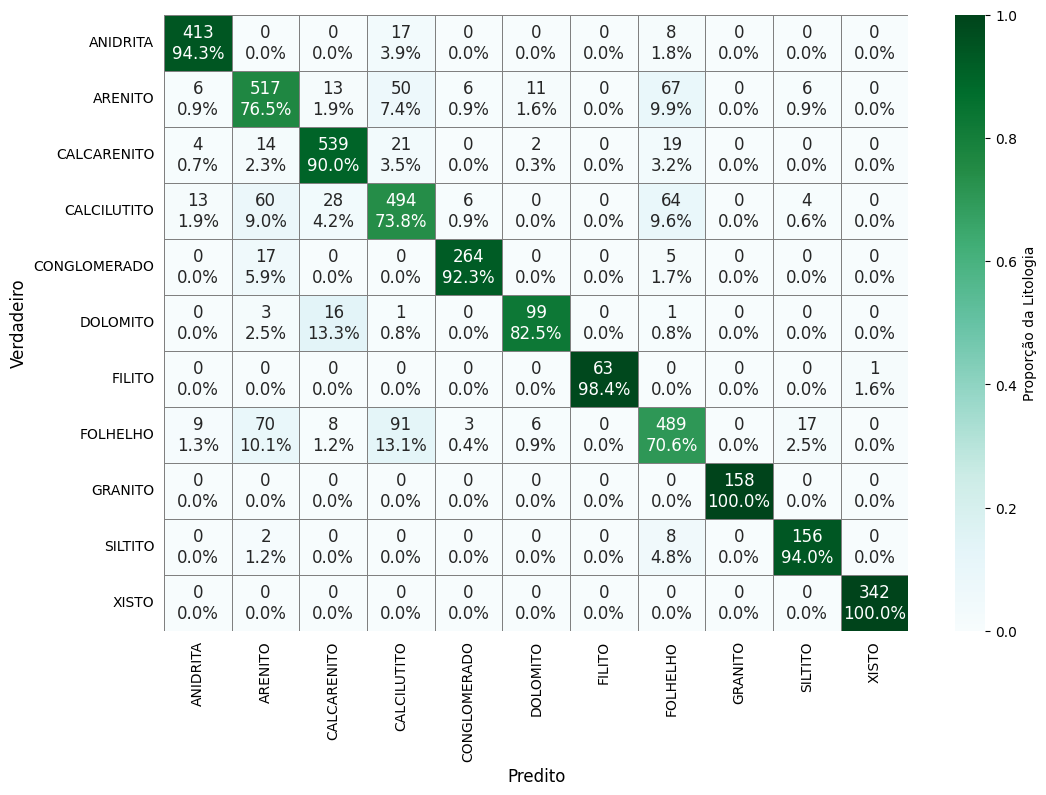

In [ ]:
# Cria a matriz de confusão (numpy.ndarray)
matriz_confusao_03 = confusion_matrix(y_03_test, y_03_pred)

cria_matriz_confusao(matriz_confusao_03, modelo_03)

### (Testar balancear folhelho por unidades)
### (Testar Quantile Transform)
### (Testar fazer um for para verificar quantidade ótima de folhelho a ser retirado)